In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import glob
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
default_columns = ('bm_name', 'NumCPU', 'manual_time')

columns = {'BM_RooFit_BinnedMultiProcGradient': ('bm_name', 'bins', 'NumCPU', 'manual_time'),
           'BM_RooFit_1DUnbinnedGaussianMultiProcessGradMinimizer': default_columns,
           'BM_RooFit_NDUnbinnedGaussianMultiProcessGradMinimizer': ('bm_name', 'NumCPU', 'dims', 'manual_time'),
           'BM_RooFit_MP_GradMinimizer_workspace_file': default_columns,
           'BM_RooFit_RooMinimizer_workspace_file': ('bm_name', 'manual_time')
          }

In [4]:
def subplots(total, wrap=None, **kwargs):
    """
    Make `total` subplots, wrapped horizontally by `wrap` columns.
    `kwargs` passed to `plt.subplots`.
    """
    if wrap is not None:
        cols = min(total, wrap)
        rows = 1 + (total - 1)//wrap
    else:
        cols = total
        rows = 1
    fig, ax = plt.subplots(rows, cols, **kwargs)
    return fig, ax

In [5]:
# def remove_outliers_from_df(df, col='real_time', group='NumCPU'):
#     values = df[col]
#     values_grouped = df.groupby(group)[col]
#     max_values_grouped = (values_grouped.mean() - np.nan_to_num(values_grouped.std())*3)

#     filter_index = values >= max_values_grouped[df[group]].reset_index(level=0)[col]
#     return df[filter_index]

In [6]:
def load_result(it=-1, **kwargs):
    json_files = sorted(glob.glob('/Users/pbos/projects/apcocsm/roofit-dev/rootbench/cmake-build-debug/root/roofit/roofit/RoofitMultiproc_*.json'))
    return load_result_file(json_files[it], **kwargs)

def load_result_file(fn, show_dfs=False, figscale=6, plot_ideal=True, match_y_axes=False):
    dfs = {}

    with open(fn) as fh:
        raw = json.load(fh)

    print(raw['context'])
    benchmarks = defaultdict(list)
    for bm in raw['benchmarks']:
        name = bm['name'].split('/')[0]
        benchmarks[name].append(bm)

    fig, ax = subplots(len(benchmarks), wrap=3,
                       figsize=(len(benchmarks)*1.1*figscale, figscale),
                       squeeze=False)
    ax = ax.flatten()

    for ix, (name, bmlist) in enumerate(benchmarks.items()):
        dfs[name] = pd.DataFrame(bmlist)
        df_names = pd.DataFrame(dfs[name].name.str.slice(start=len("BM_RooFit_")).str.split('/').values.tolist(), columns=columns[name])
        for c in columns[name][1:-1]:
            df_names[c] = pd.to_numeric(df_names[c])
        dfs[name] = dfs[name].join(df_names)
        # Drop mean, median and std results, only keep normal timings (we do stats ourselves):
        dfs[name] = dfs[name][dfs[name]['manual_time'] == 'manual_time']
        dfs[name] = dfs[name].drop(['name', 'manual_time', 'cpu_time', 'iterations', 'time_unit'], axis=1)#, 'iterations'], axis=1)
        if show_dfs:
            display(dfs[name])
        
#         if remove_outliers:
#             dfs[name] = remove_outliers_from_df(dfs[name])
            
        if name == 'BM_RooFit_BinnedMultiProcGradient':
            hue = 'bins'
        elif name == 'BM_RooFit_NDUnbinnedGaussianMultiProcessGradMinimizer':
            hue = 'dims'
        else:
            hue = None
        
        # for single core runs, add NumCPU column:
        if 'NumCPU' not in dfs[name].columns:
            dfs[name]['NumCPU'] = 1
            if plot_ideal:
                print("Not plotting ideal, since this was only a single core run")
                plot_ideal = False
        
        dfs[name]["real or ideal"] = "real"
        
#         if hue is not None:
#             leg_handles, leg_labels = ax[ix].get_legend_handles_labels()
        
        ax[ix].set_title(name)
        
        if plot_ideal:
            if hue is not None:
                min_single_core = dfs[name][dfs[name]['NumCPU'] == 1].groupby(hue)['real_time'].min()
                df_ideal = min_single_core.to_frame('real_time')
                df_ideal.reset_index(level=0, inplace=True)
            else:
                min_single_core = dfs[name][dfs[name]['NumCPU'] == 1]['real_time'].min()
                df_ideal = pd.DataFrame({'real_time': [min_single_core]})
            numCPU = np.unique(dfs[name]['NumCPU'])
            numCPU.sort()
            df_numCPU = pd.Series(numCPU, name='NumCPU').to_frame()
            # necessary for doing a cross merge (cartesian product):
            df_numCPU['key'] = 1
            df_ideal['key'] = 1
            df_ideal = df_ideal.merge(df_numCPU, on='key', how='outer').drop('key', axis=1)
            df_ideal['real_time'] /= df_ideal['NumCPU']
            df_ideal['real or ideal'] = "ideal"
            dfs[name] = pd.concat([dfs[name], df_ideal], sort=False)

        sns.lineplot(data=dfs[name], x='NumCPU', y='real_time', hue=hue, style="real or ideal",
                     markers=True, err_style="bars", legend='full',
                     ax=ax[ix])

#             sns.pointplot(data=df_ideal, x='NumCPU', y='ideal_time', hue=hue, ax=ax[ix], linestyles='--')
            
#             # remove duplicate legend labels by resetting to what they were before the ideal plot addition
#             if hue is not None:
#                 ax[ix].legend(leg_handles, leg_labels, title=hue)

    if match_y_axes:
        ymin, ymax = ax[0].get_ylim()
        for axi in ax:
            ymin = min(ymin, axi.get_ylim()[0])
            ymax = max(ymax, axi.get_ylim()[1])

        for axi in ax:
            axi.set_ylim((ymin, ymax))
    
    return dfs

{'date': '2018-12-19 10:33:06', 'num_cpus': 4, 'mhz_per_cpu': 2900, 'cpu_scaling_enabled': False, 'library_build_type': 'debug'}


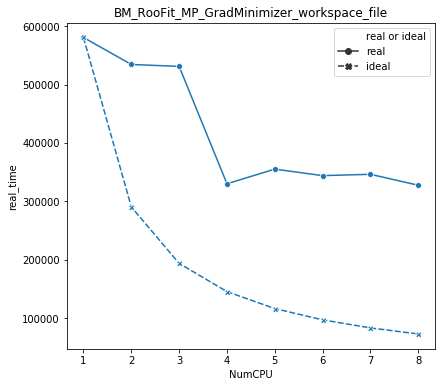

In [7]:
_ = load_result()

{'date': '2018-12-18 13:08:29', 'num_cpus': 80, 'mhz_per_cpu': 2400, 'cpu_scaling_enabled': False, 'library_build_type': 'release'}


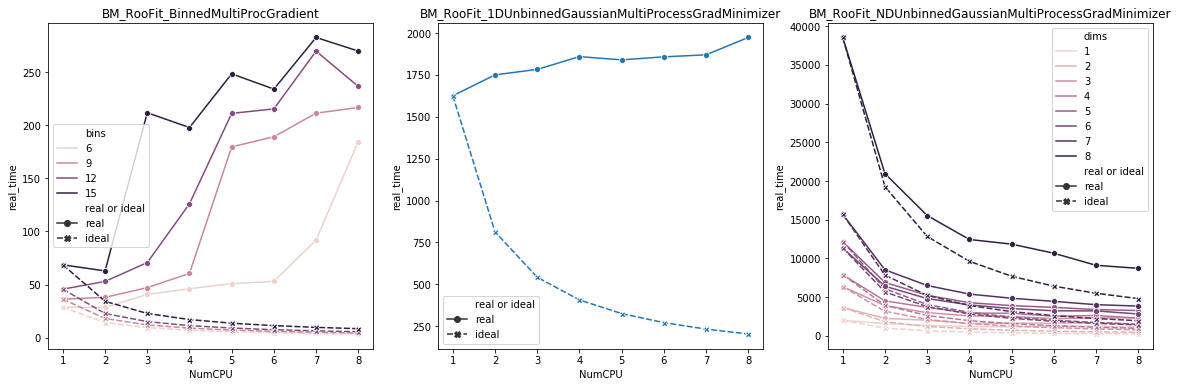

In [8]:
dfs = load_result_file('stbc-i5_marks/RoofitMultiproc_1545134908.json')

In [9]:
dfs.keys()

dict_keys(['BM_RooFit_BinnedMultiProcGradient', 'BM_RooFit_1DUnbinnedGaussianMultiProcessGradMinimizer', 'BM_RooFit_NDUnbinnedGaussianMultiProcessGradMinimizer'])

In [10]:
# dfs['BM_RooFit_BinnedMultiProcGradient']

# Stoomboot

{'date': '2019-01-14 16:16:14', 'num_cpus': 64, 'mhz_per_cpu': 1996, 'cpu_scaling_enabled': False, 'library_build_type': 'release'}


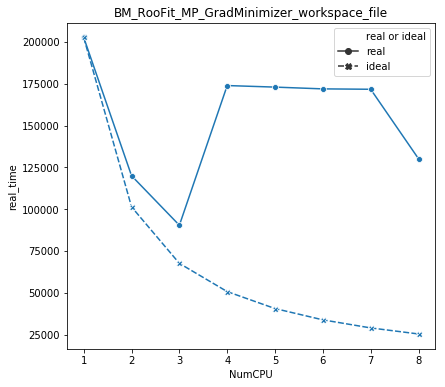

In [11]:
# op centos7 machine (zijn dus idd 64 cpus, had maar 8 gereserveerd!)
dfs = load_result_file('../rootbench/1461350.burrell.nikhef.nl/RoofitMPworkspace_1547478971.json')

In [12]:
dfs

{'BM_RooFit_MP_GradMinimizer_workspace_file':        real_time                          bm_name  NumCPU real or ideal
 0  202666.572988  MP_GradMinimizer_workspace_file       1          real
 1  119958.064698  MP_GradMinimizer_workspace_file       2          real
 2   90353.822164  MP_GradMinimizer_workspace_file       3          real
 3  173906.495663  MP_GradMinimizer_workspace_file       4          real
 4  172978.698826  MP_GradMinimizer_workspace_file       5          real
 5  171917.000181  MP_GradMinimizer_workspace_file       6          real
 6  171687.454019  MP_GradMinimizer_workspace_file       7          real
 7  130126.830523  MP_GradMinimizer_workspace_file       8          real
 0  202666.572988                              NaN       1         ideal
 1  101333.286494                              NaN       2         ideal
 2   67555.524329                              NaN       3         ideal
 3   50666.643247                              NaN       4         ideal
 4   4

# Stoomboot: meerdere repetitions

{'date': '2019-01-16 05:46:09', 'num_cpus': 64, 'mhz_per_cpu': 1996, 'cpu_scaling_enabled': False, 'library_build_type': 'release'}


/Users/pbos/sw/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


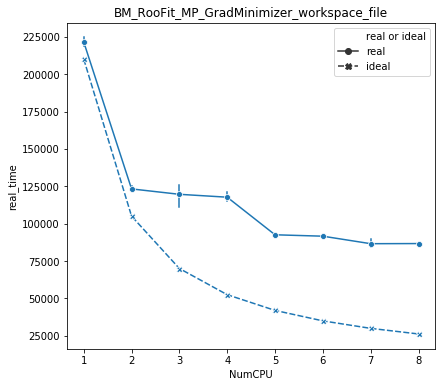

In [13]:
# op centos7 machine (nu wel ook 32 CPUs (= max) gereserveerd)
dfs = load_result_file('../rootbench/1464718.burrell.nikhef.nl/RoofitMPworkspace_1547613964.json')

## RooMinimizer also included
The first run was without optConst = 2 and Minuit2 not activated on RooMinimizer. Probably Minuit1 is what causes the RooMinimizer run to be slightly slower than the single core GradMinimizer case.

{'date': '2019-01-16 14:32:34', 'num_cpus': 64, 'mhz_per_cpu': 1996, 'cpu_scaling_enabled': False, 'library_build_type': 'release'}
Not plotting ideal, since this was only a single core run


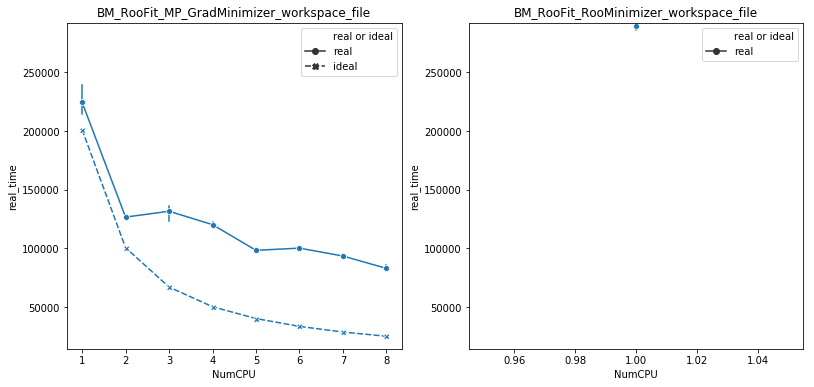

In [14]:
# op centos7 machine (nu wel ook 32 CPUs (= max) gereserveerd)
dfs = load_result_file('../rootbench/1469398.burrell.nikhef.nl/RoofitMPworkspace_1547645550.json', match_y_axes=True)

The next run does have optConst = 2 and minimizerType = Minuit2 for RooMinimizer. As we see, about 10x (!!!) faster than without optConst = 2. Also, the RooMinimizer case is now a bit faster again than the GradMinimizer case.

{'date': '2019-01-17 11:27:13', 'num_cpus': 64, 'mhz_per_cpu': 1996, 'cpu_scaling_enabled': False, 'library_build_type': 'release'}
Not plotting ideal, since this was only a single core run


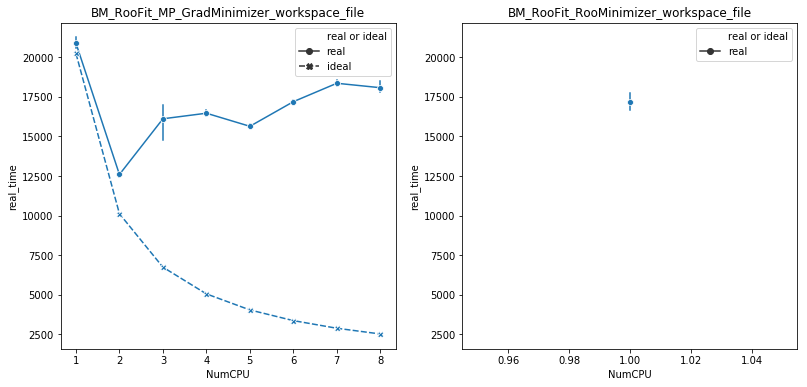

In [15]:
dfs = load_result_file('../rootbench/1471528.burrell.nikhef.nl/RoofitMPworkspace_1547720829.json', match_y_axes=True)

# Split up timings
The out logs contain more detailed timing information, split up into communication (update step) and actual gradient calculation. We will now extract this information.

In [16]:
def extract_split_timing_info(fn):
    with open(fn, 'r') as fh:
        lines = fh.read().splitlines()
    
    bm_iterations = []
    
    start_indices = []
    end_indices = []
    for ix, line in enumerate(lines):
        if line == 'start migrad':
            start_indices.append(ix)
        elif line == 'end migrad':
            end_indices.append(ix)
    
    start_indices_clean = []
    for ix, index in enumerate(start_indices):
        try:
            if start_indices[ix + 1] != index + 1:
                start_indices_clean.append(index)
        except IndexError:
            start_indices_clean.append(index)

    for ix in range(len(start_indices_clean)):
        bm_iterations.append(lines[start_indices_clean[ix]+1:end_indices[ix]])
    
    return bm_iterations

In [17]:
def build_df_split_timing_run(timing_string_list):
    data = {'time_s': [], 'timing_type': []}
    for line in timing_string_list:
        words = line.split()
        data['time_s'].append(float(words[1][:-2]))
        data['timing_type'].append('update state')
        data['time_s'].append(float(words[4][:-1]))
        data['timing_type'].append('gradient work')
    return pd.DataFrame(data)

In [18]:
def build_dflist_split_timing_info(fn):
    bm_iterations = extract_split_timing_info(fn)
    
    dflist = []
    for bm in bm_iterations:
        dflist.append(build_df_split_timing_run(bm))
    
    return dflist

In [19]:
def build_comb_df_split_timing_info(fn):
    dflist = build_dflist_split_timing_info(fn)
    
    ix = 0
    for df in dflist:
        df["benchmark_number"] = ix
        ix += 1
    
    return pd.concat(dflist)

In [21]:
df_split_timings = build_comb_df_split_timing_info('../rootbench/1471528.burrell.nikhef.nl.out')

In [30]:
df_split_timings.columns

Index(['time_s', 'timing_type', 'benchmark_number'], dtype='object')

{'date': '2019-01-17 11:27:13', 'num_cpus': 64, 'mhz_per_cpu': 1996, 'cpu_scaling_enabled': False, 'library_build_type': 'release'}
Not plotting ideal, since this was only a single core run


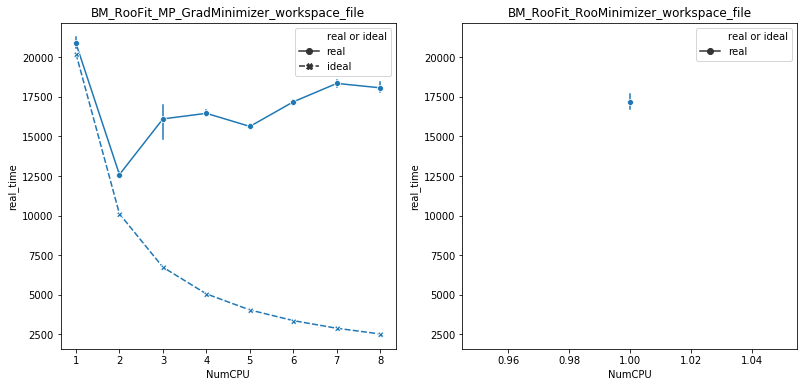

In [23]:
dfs = load_result_file('../rootbench/1471528.burrell.nikhef.nl/RoofitMPworkspace_1547720829.json', match_y_axes=True)

In [68]:
df_total_timings = dfs['BM_RooFit_MP_GradMinimizer_workspace_file']
# df_total_timings = df_total_timings[df_total_timings["real or ideal"] == 'real']

In [69]:
len(df_split_timings.groupby('benchmark_number')), len(df_total_timings)

(80, 88)

In [121]:
df_update_timings = df_split_timings[df_split_timings['timing_type'] == 'update state'].drop('timing_type', axis=1).rename(columns={'time_s': 'update'})
df_gradient_timings = df_split_timings[df_split_timings['timing_type'] == 'gradient work'].drop('timing_type', axis=1).rename(columns={'time_s': 'gradient'})

In [122]:
# df_update_timings.groupby('benchmark_number').sum()

In [123]:
df_all_timings = \
df_total_timings.reset_index() \
                .join(df_update_timings.groupby('benchmark_number').sum()) \
                .join(df_gradient_timings.groupby('benchmark_number').sum())
df_all_timings['real_time'] /= 1000  # convert to seconds
df_all_timings.rename(inplace=True, columns={'real_time': 'total'})

In [124]:
df_all_timings = df_all_timings.set_index(['index', 'bm_name', 'NumCPU', 'real or ideal']).stack()

In [146]:
df_all_timings = df_all_timings.to_frame().rename_axis(['index', 'bm_name', 'NumCPU', 'real or ideal', 'timing_type']).rename(columns={0: 'time [s]'})
df_all_timings = df_all_timings.reset_index()

AttributeError: 'DataFrame' object has no attribute 'to_frame'

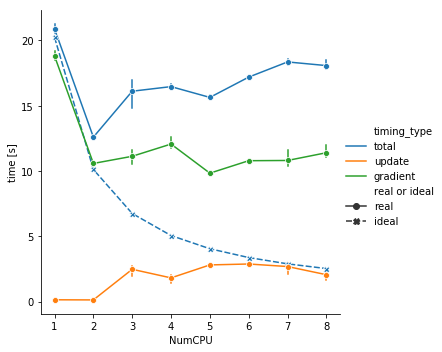

In [149]:
sns.relplot(data=df_all_timings, x='NumCPU', y='time [s]', style="real or ideal",
#             col='timing_type',
            hue='timing_type',
            markers=True, err_style="bars", legend='full', kind="line")

# Skype met Wouter
_(Di 29 Jan, ~14h)_

Kijken naar tabel met opgesplitste resultaten:
- Opvallend: gradient time schaalt helemaal niet netjes! Dat zou je wel verwachten...
- Update/communicatie tijd schaalt wel wat omhoog, maar zeker niet dominant.
- "Rest tijd" wordt ook steeds meer.

Checken:
* BELANGRIJKSTE: Wat voor derivatives zijn het? Tijdsverdeling van derivatives. Met name tijd van langste berekeing; als dat meer is dan een 1/8e, dan is de ideal tijd ook anders!
* Elke worker node welke derivatives hij gedaan heeft.
* Seconden wall time van elke worker node --> load balancing.
* Werk terug van de queue.
* Wat is de derde component?
* Ook breakdown van ND-Gaussians